In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from paretoset import paretoset

import model_functions as fmodel

# Matrix ISA Model Example Usage

### Number of Registers to Hide Memory Latency

using larger memories with higher latency requires more matrix registers to acheive high utilization. below is a plot showing how utilization is affected by memory latency for different matrix register counts.

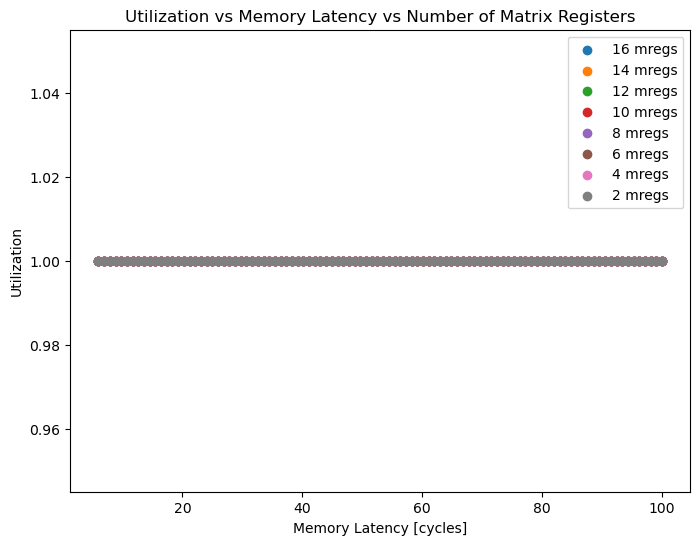

In [2]:
fig, axs = plt.subplots(figsize=(8,6))
axs.set_title('Utilization vs Memory Latency vs Number of Matrix Registers')
axs.set_xlabel('Memory Latency [cycles]')
axs.set_ylabel('Utilization')

level = 1
databits = np.array([32])
slice_values = np.linspace(6, 100, 100)
num_mregs = np.array(range(16, 0, -2))
for n in num_mregs:
    perf_model = fmodel.init_pm(databits, t_mem=slice_values, num_mregs=np.array([n]))

    x = perf_model.index.levels[level]
    y = perf_model['util']
    scatter = axs.scatter(x, y, label=f'{n} mregs')
    axs.legend()

/var/folders/hc/58trqhn5091504q0fyxy68jc0000gn/T/ipykernel_73298/839808576.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axs.scatter(x, y, cmap='viridis', s=100)


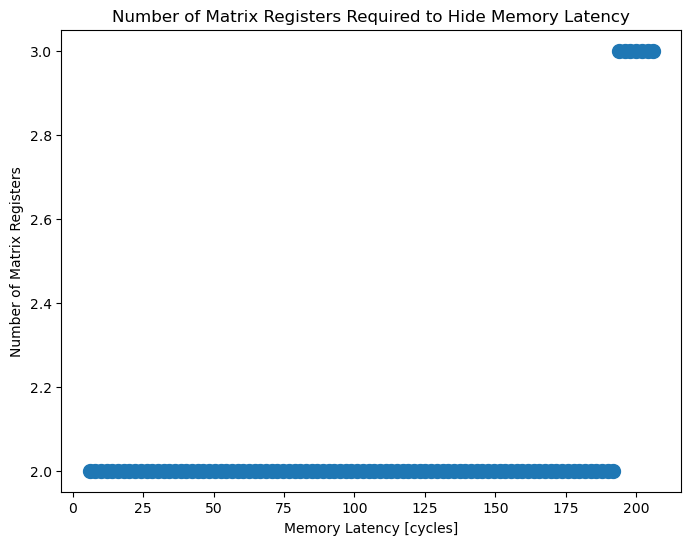

In [3]:
level = 1
slice_values = np.linspace(6,206,100)
perf_model = fmodel.init_pm(t_mem=slice_values)

fig, axs = plt.subplots(figsize=(8,6))
axs.set_title('Number of Matrix Registers Required to Hide Memory Latency')
axs.set_xlabel('Memory Latency [cycles]')
axs.set_ylabel('Number of Matrix Registers')

x = perf_model.index.levels[level]
y = perf_model['max_mregs']
scatter = axs.scatter(x, y, cmap='viridis', s=100)

TypeError: init_pm() got an unexpected keyword argument 'width_mmu'

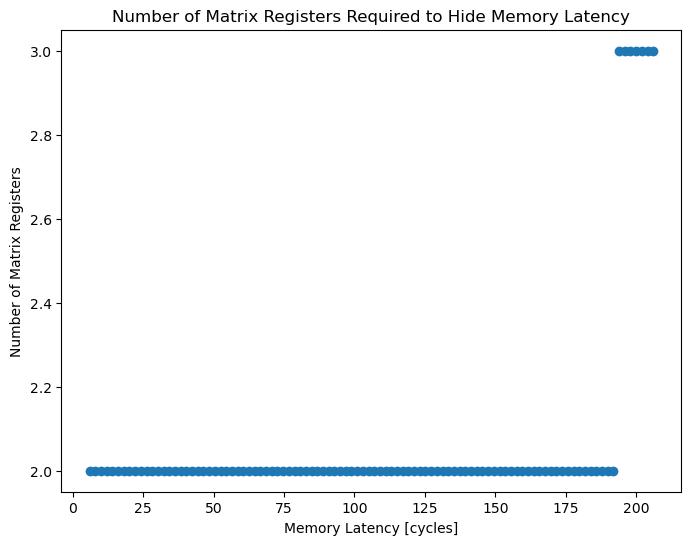

In [ ]:
fig, axs = plt.subplots(figsize=(8,6))
axs.set_title('Number of Matrix Registers Required to Hide Memory Latency')
axs.set_xlabel('Memory Latency [cycles]')
axs.set_ylabel('Number of Matrix Registers')
scatter = axs.scatter(x, y, label='Full Width Datapath')

level = 1
slice_values = np.linspace(6,206,100)
perf_model = fmodel.init_pm(t_mem=slice_values,width_datapath=np.array([0.5]))

x = perf_model.index.levels[level]
y = perf_model['max_mregs']
scatter = axs.scatter(x, y, label='Half Width Datapath')
axs.legend()

### Exploring Design Space

The model can be used to sweep ranges of the input parameters, and the output performance specs can be visualized using pareto-optimal curves.

With these plots we can visualize the tradeoffs between ngates capacity, memory bandwidth, and performance (operations per cycle).

t_uk  \
databits t_mem M  N  K  l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu          
8        20    4  20 4  128      1  16.0 16.0 2         0    4     0.5        184.0   
                                         32.0 2         0    4     0.5        312.0   
                                         48.0 2         0    4     0.5        440.0   
                                         64.0 2         0    4     0.5        568.0   
                  36 4  128      1  16.0 16.0 2         0    4     0.5        184.0   
...                                                                             ...   
               60 60 4  128      1  64.0 64.0 2         0    4     0.5        568.0   
                     60 128      1  16.0 16.0 2         0    4     0.5        408.0   
                                              4         0    4     0.5        408.0   
                                         32.0 2         0    4     0.5        536.0   
                                         48.0 2         0    4     0.5        664.0   

                                                                                  util  \
databits t_mem M  N  K  l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu             
8        20    4  20 4  128      1  16.0 16.0 2         0    4     0.5        0.156250   
                                         32.0 2         0    4     0.5        0.078125   
                                         48.0 2         0    4     0.5        0.052083   
                                         64.0 2         0    4     0.5        0.039062   
                  36 4  128      1  16.0 16.0 2         0    4     0.5        0.187500   
...                                                                                ...   
               60 60 4  128      1  64.0 64.0 2         0    4     0.5        0.878906   
                     60 128      1  16.0 16.0 2         0    4     0.5        0.878906   
                                              4         0    4     0.5        0.878906   
                                         32.0 2         0    4     0.5        0.878906   
                                         48.0 2         0    4     0.5        0.585938   

                                                                              ops_cycle  \
databits t_mem M  N  K  l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu              
8        20    4  20 4  128      1  16.0 16.0 2         0    4     0.5             40.0   
                                         32.0 2         0    4     0.5             40.0   
                                         48.0 2         0    4     0.5             40.0   
                                         64.0 2         0    4     0.5             40.0   
                  36 4  128      1  16.0 16.0 2         0    4     0.5             48.0   
...                                                                                 ...   
               60 60 4  128      1  64.0 64.0 2         0    4     0.5           3600.0   
                     60 128      1  16.0 16.0 2         0    4     0.5            225.0   
                                              4         0    4     0.5            225.0   
                                         32.0 2         0    4     0.5            450.0   
                                         48.0 2         0    4     0.5            450.0   

                                                                              max_mregs  \
databits t_mem M  N  K  l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu              
8        20    4  20 4  128      1  16.0 16.0 2         0    4     0.5              2.0   
                                         32.0 2         0    4     0.5              2.0   
                                         48.0 2         0    4     0.5              2.0   
                                         64.0 2         0    4     0.5              2.0   
                  36 4  128      1  16.0 16.0 

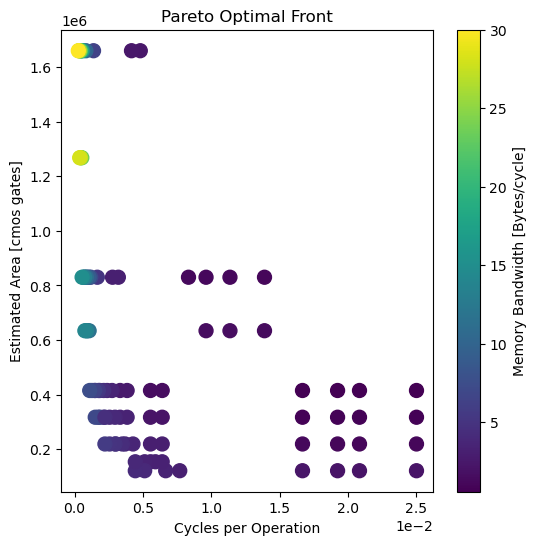

In [5]:
perf_model = fmodel.init_pm(
    mlB = np.array(range(128,513, 128))/8,
    vlB = np.array([128, 256, 512])/8,
    N = np.array(range(4,64, 8)),
    M = np.array(range(4,64, 8)),
    K = np.array(range(4,64, 8)),
    num_mregs = np.array(range(2,6,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([0.5, 1])
)
perf_model = perf_model[perf_model['blas_mem_bw'] <= 64]
perf_model = perf_model[perf_model['ops_cycle'] >= 1/4e-2]

pm_pareto = perf_model[['ops_cycle','opu_area', 'blas_mem_bw']]
mask = paretoset(pm_pareto, sense=['max', 'min', 'min'])

bw = perf_model.loc[mask,'blas_mem_bw']
ngates = perf_model.loc[mask,'opu_area']
opc = perf_model.loc[mask,'ops_cycle']

fig, axs = plt.subplots(1,figsize=(6,6))
axs.set_title('Pareto Optimal Front')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Estimated Area [cmos gates]')

scatter = axs.scatter(1/opc, ngates, c=bw, cmap='viridis', s=100)
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.colorbar(scatter, ax=axs, label='Memory Bandwidth [Bytes/cycle]')
perf_model[mask]

t_uk  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu          
8        20    4  12 4 128      1  64.0 32.0 2         0    4     0.5        312.0   
                                        48.0 2         0    4     0.5        440.0   
                                        64.0 2         0    4     0.5        568.0   
               20 4  4 128      1  64.0 16.0 2         0    4     0.5        184.0   

                                                                                 util  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu             
8        20    4  12 4 128      1  64.0 32.0 2         0    4     0.5        0.023438   
                                        48.0 2         0    4     0.5        0.015625   
                                        64.0 2         0    4     0.5        0.011719   
               20 4  4 128      1  64.0 16.0 2         0    4     0.5        0.039062   

                                                                             ops_cycle  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu              
8        20    4  12 4 128      1  64.0 32.0 2         0    4     0.5             48.0   
                                        48.0 2         0    4     0.5             48.0   
                                        64.0 2         0    4     0.5             48.0   
               20 4  4 128      1  64.0 16.0 2         0    4     0.5             40.0   

                                                                             max_mregs  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu              
8        20    4  12 4 128      1  64.0 32.0 2         0    4     0.5              2.0   
                                        48.0 2         0    4     0.5              2.0   
                                        64.0 2         0    4     0.5              2.0   
               20 4  4 128      1  64.0 16.0 2         0    4     0.5              2.0   

                                                                             max_mrf_capacity  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu                     
8        20    4  12 4 128      1  64.0 32.0 2         0    4     0.5                     2.0   
                                        48.0 2         0    4     0.5                     2.0   
                                        64.0 2         0    4     0.5                     2.0   
               20 4  4 128      1  64.0 16.0 2         0    4     0.5                    10.0   

                                                                             blas_mem_bw  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu                
8        20    4  12 4 128      1  64.0 32.0 2         0    4     0.5           4.000000   
                                        48.0 2         0    4     0.5           2.720000   
                                        64.0 2         0    4     0.5           2.060606   
               20 4  4 128      1  64.0 16.0 2         0    4     0.5          18.111111   

                                                                             nmk_mem_bw  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu               
8        20    4  12 4 128      1  64.0 32.0 2         0    4     0.5          1.000000   
                                        48.0 2         0    4     0.5          0.680000   
                                        64.0 2         0    4     0.5          0.515152   
               20 4  4 128      1  64.0 16.0 2         0    4     0.5          2.055556   

                                                                                mrf_bw  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op widen width_mmu              
8        20    4  12 4 128      1  64.0 32.0 2         0    4     0.5         5.1

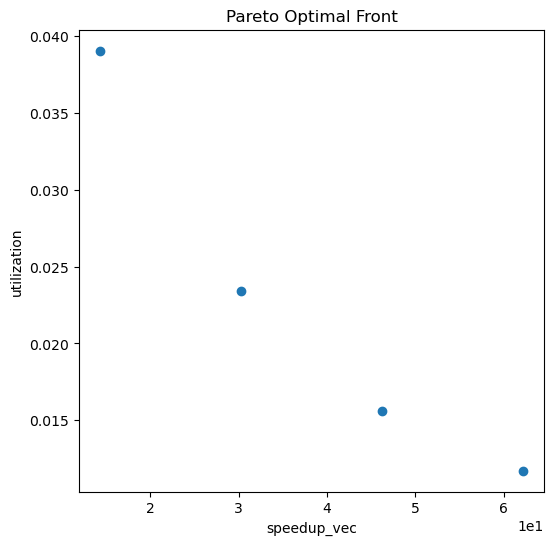

In [6]:
pm_pareto = perf_model[['speedup_vec','util']]
mask = paretoset(pm_pareto, sense=['min', 'min'])

speedup_vec = perf_model.loc[mask,'speedup_vec']
util = perf_model.loc[mask,'util']

fig, axs = plt.subplots(1,figsize=(6,6))
axs.set_title('Pareto Optimal Front')
axs.set_xlabel('speedup_vec')
axs.set_ylabel('utilization')

scatter = axs.scatter(speedup_vec, util)
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
perf_model[mask]

In [10]:

# mlB = np.array(range(128,513, 32))/8
mlB = np.array([128, 256, 512])/8
vlB = np.array([128, 256, 512])/8
num_mregs = np.array(range(2,6,2))
t_op = np.array([0, 1])
width_datapath = np.array([0.5, 1])

def plot_nmk_scatter(x, y):
    fig, axs = plt.subplots(len(t_op), len(width_datapath), figsize=(18, 18))
    for m in range(len(t_op)):
        for n in range(len(width_datapath)):
                perf_model = fmodel.init_pm(t_op=np.array([t_op[m]]), width_datapath=np.array([width_datapath[n]]),                   
                                            N = np.array(range(4,64, 8)),
                                            M = np.array(range(4,64, 8)),
                                            K = np.array(range(4,64, 8)))

                # Create a 3x3 subplot
                ax = axs[m,n]
                ax.set_title(f'Speedup vs Utilization for MLEN={int(mlB[m]*8)} and VLEN={int(8*vlB[n])}')
                ax.set_xlabel('Speedup over Vector Unit')
                ax.set_ylabel('Utilization')
                perf_model['tile_size'] = perf_model.index.get_level_values('N') * perf_model.index.get_level_values('M')
                scatter = ax.scatter(perf_model['speedup_vec'], perf_model['util'],  
                                        c=perf_model['tile_size'], cmap='viridis')
                cbar = plt.colorbar(scatter, ax=ax)
    plt.show()

#### Memory Data Reuse
If the matrices are sufficiently large to reuse tiles, then bandwidth can be decreased:

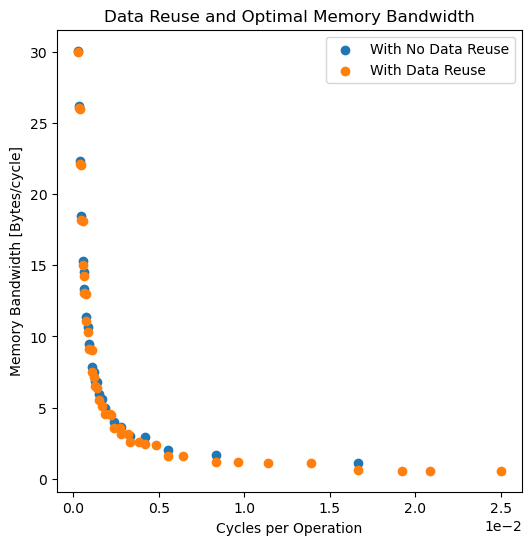

In [8]:
no_reuse_pm = perf_model.copy()
pm_pareto = no_reuse_pm[['ops_cycle','mrf_bw']]
mask = paretoset(pm_pareto, sense=['max', 'min'])

bw = no_reuse_pm.loc[mask,'mrf_bw']
opc = no_reuse_pm.loc[mask,'ops_cycle']

fig, axs = plt.subplots(1,figsize=(6,6))
scatter = axs.scatter(1/opc, bw, label='With No Data Reuse')

reuse_perf_model = perf_model.copy()
reuse_perf_model = reuse_perf_model[reuse_perf_model['blas_mem_bw'] <= 64]
reuse_perf_model = reuse_perf_model[reuse_perf_model['ops_cycle'] >= 1/(4e-2)]

pm_pareto = reuse_perf_model[['ops_cycle','blas_mem_bw']]
reuse_mask = paretoset(pm_pareto, sense=['max', 'min'])

bw = reuse_perf_model.loc[reuse_mask,'blas_mem_bw']
opc = reuse_perf_model.loc[reuse_mask,'ops_cycle']

scatter = axs.scatter(1/opc, bw, label='With Data Reuse')
axs.set_title('Data Reuse and Optimal Memory Bandwidth')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Memory Bandwidth [Bytes/cycle]')
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs.legend()


t_uk  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath          
8        200   64 64 64 256      1  16.0 1     2         0    4     1               496.0   
                                         2     2         0    4     1               480.0   
                                    32.0 1     2         0    4     1               528.0   
                                         2     2         0    4     1               496.0   
                                    64.0 1     2         0    4     1               592.0   
                                         2     2         0    4     1               528.0   

                                                                                    util  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath         
8        200   64 64 64 256      1  16.0 1     2         0    4     1                1.0   
                                         2     2         0    4     1                1.0   
                                    32.0 1     2         0    4     1                1.0   
                                         2     2         0    4     1                1.0   
                                    64.0 1     2         0    4     1                1.0   
                                         2     2         0    4     1                1.0   

                                                                                    ops_cycle  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        200   64 64 64 256      1  16.0 1     2         0    4     1                   256.0   
                                         2     2         0    4     1                   128.0   
                                    32.0 1     2         0    4     1                  1024.0   
                                         2     2         0    4     1                   512.0   
                                    64.0 1     2         0    4     1                  4096.0   
                                         2     2         0    4     1                  2048.0   

                                                                                    max_mregs  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        200   64 64 64 256      1  16.0 1     2         0    4     1                     6.0   
                                         2     2         0    4     1                     6.0   
                                    32.0 1     2         0    4     1                     5.0   
                                         2     2         0    4     1                     6.0   
                                    64.0 1     2         0    4     1                     4.0   
                                         2     2         0    4     1                     5.0   

                                                                                    max_mrf_capacity  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                     
8        200   64 64 64 256      1  16.0 1     2         0    4     1                           12.0   
                                         2     2         0    4     1                            6.0   
                                    32.0 1     2         0    4     1                           40.0   
                                         2     2         0    4     1                           24.0   
                                    64.0 1     2         0    4     1                           64.0   
                                         2     2         0    4     1                           80.0   

                                                                                    blas_mem_bw  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                
8        200   64 

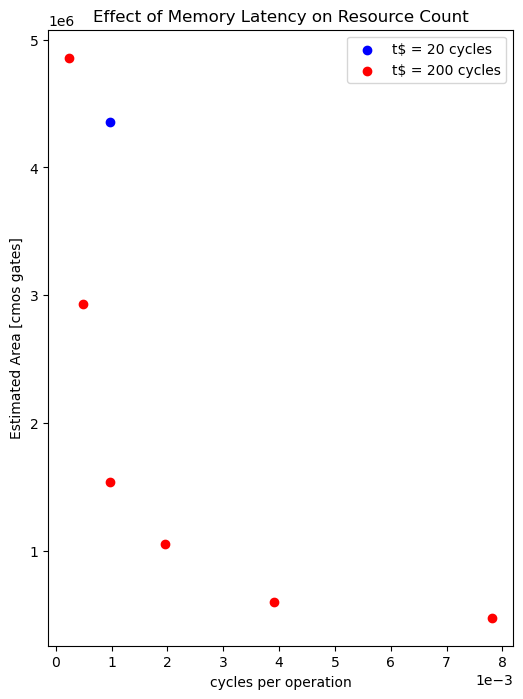

In [9]:
tm20_perf_model = perf_model.copy()
tm200_perf_model = fmodel.init_pm(
    t_mem = np.array([200]),
    l2_cache = np.array([256]),
    vlB = np.array([128, 256, 512])/8,
    vl_ml = np.array([1,2]),
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([1])
)
# tm20_perf_model = tm20_perf_model[tm20_perf_model['blas_mem_bw'] <= 64]
# tm20_perf_model = tm20_perf_model[tm20_perf_model['opu_area'] <= 3.2e6]
# tm20_perf_model = tm20_perf_model[tm20_perf_model['ops_cycle'] >= 10]

# tm200_perf_model = tm200_perf_model[tm200_perf_model['blas_mem_bw'] <= 64]
# tm200_perf_model = tm200_perf_model[tm200_perf_model['opu_area'] <= 3.2e6]
# tm200_perf_model = tm200_perf_model[tm200_perf_model['ops_cycle'] >= 10]

tm20_pm_pareto = tm20_perf_model[['ops_cycle','opu_area']]
tm20_mask = paretoset(tm20_pm_pareto, sense=['max', 'min'])

tm200_pm_pareto = tm200_perf_model[['ops_cycle','opu_area']]
tm200_mask = paretoset(tm200_pm_pareto, sense=['max', 'min'])

fig, axs = plt.subplots(1,figsize=(6,8))
axs.set_title('Effect of Memory Latency on Resource Count')
axs.set_xlabel('cycles per operation')
axs.set_ylabel('Estimated Area [cmos gates]')

bw = tm20_perf_model.loc[tm20_mask,'blas_mem_bw']
ngates = tm20_perf_model.loc[tm20_mask,'opu_area']
opc = tm20_perf_model.loc[tm20_mask,'ops_cycle']
scatter = axs.scatter(1/opc, ngates, color='b', label='t$ = 20 cycles')

bw = tm200_perf_model.loc[tm200_mask,'blas_mem_bw']
ngates = tm200_perf_model.loc[tm200_mask,'opu_area']
opc = tm200_perf_model.loc[tm200_mask,'ops_cycle']
scatter = axs.scatter(1/opc, ngates, color='r', label='t$ = 200 cycles')

axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs.legend()
tm200_perf_model[tm200_mask]

We can compare these tradeoffs for half-width and full-width MMU datapaths:

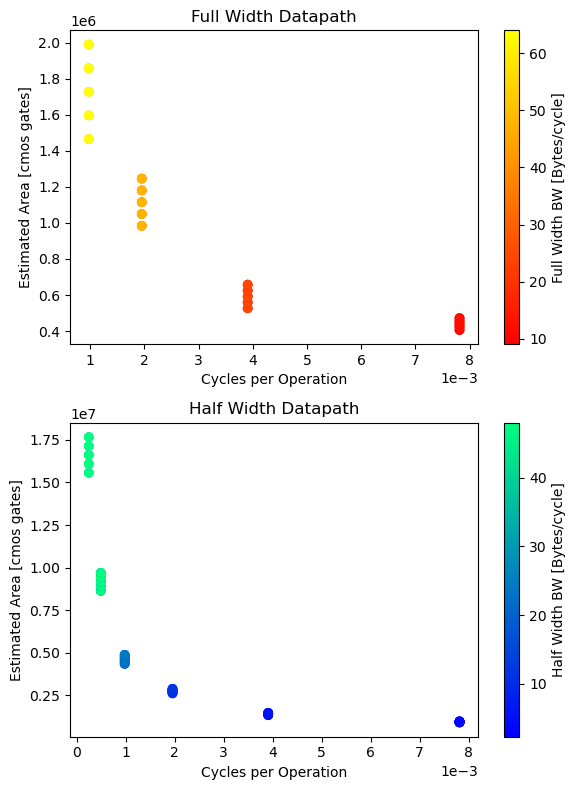

In [13]:
perf_model = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    N = np.array(range(4,64, 8)),
    M = np.array(range(4,64, 8)),
    K = np.array(range(4,64, 8)),
    num_mregs = np.array(range(2,6,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([0.5, 1])
)
perf_model_t1 = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([1])
)
perf_model_t4 = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([0.5])
)
perf_model_t1 = perf_model_t1[perf_model_t1['blas_mem_bw'] <= 64]
bw = perf_model_t1['blas_mem_bw']
ngates = perf_model_t1['opu_area']
opc = perf_model_t1['ops_cycle']

perf_model_t4 = perf_model_t4[perf_model_t4['blas_mem_bw'] <= 64]
bw_t4 = perf_model_t4['blas_mem_bw']
ngates_t4 = perf_model_t4['opu_area']
opc_t4 = perf_model_t4['ops_cycle']

fig, axs = plt.subplots(2, figsize=(6, 8))
# Plot for full width datapath
axs[0].set_title('Full Width Datapath')
axs[0].set_xlabel('Cycles per Operation')
axs[0].set_ylabel('Estimated Area [cmos gates]')
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
full = axs[0].scatter(1/opc, ngates, c=bw, cmap='autumn', label='full width')
fig.colorbar(full, ax=axs[0], label='Full Width BW [Bytes/cycle]')

# Plot for half width datapath
axs[1].set_title('Half Width Datapath')
axs[1].set_xlabel('Cycles per Operation')
axs[1].set_ylabel('Estimated Area [cmos gates]')
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
half = axs[1].scatter(1/opc_t4, ngates_t4, c=bw_t4, cmap='winter', label='half width')
fig.colorbar(half, ax=axs[1], label='Half Width BW [Bytes/cycle]')
plt.tight_layout()
plt.show()


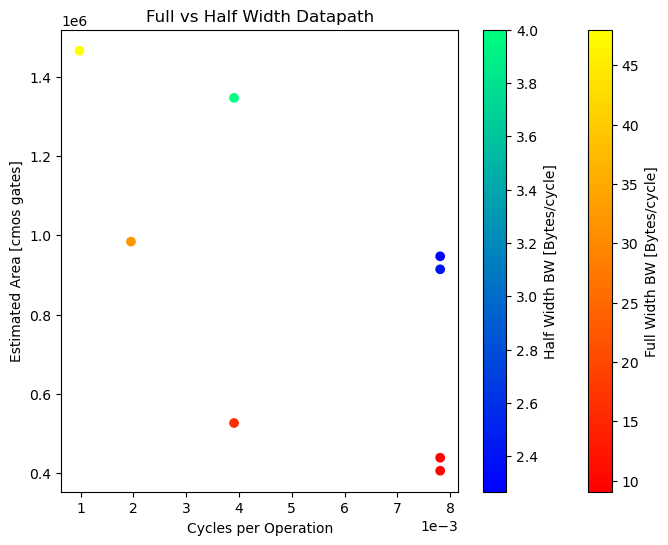

In [14]:
perf_model_t1 = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([1])
)
perf_model_t4 = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([0.5])
)
perf_model_t1 = perf_model_t1[perf_model_t1['blas_mem_bw'] <= 64]
perf_model_t1 = perf_model_t1[perf_model_t1['opu_area'] <= 2e6]
perf_model_t1 = perf_model_t1[perf_model_t1['ops_cycle'] >= 1/3.5e-2]

pm_pareto = perf_model_t1[['ops_cycle','opu_area', 'blas_mem_bw']]
mask = paretoset(pm_pareto, sense=['max', 'min', 'min'])

bw = perf_model_t1.loc[mask,'blas_mem_bw']
ngates = perf_model_t1.loc[mask,'opu_area']
opc = perf_model_t1.loc[mask,'ops_cycle']

perf_model_t4 = perf_model_t4[perf_model_t4['blas_mem_bw'] <= 64]
perf_model_t4 = perf_model_t4[perf_model_t4['opu_area'] <= 2e6]
perf_model_t4 = perf_model_t4[perf_model_t4['ops_cycle'] >= 1/3.5e-2]

pm_pareto_t4 = perf_model_t4[['ops_cycle','opu_area', 'blas_mem_bw']]
mask_t4 = paretoset(pm_pareto_t4, sense=['max', 'min', 'min'])

bw_t4 = perf_model_t4.loc[mask_t4,'blas_mem_bw']
ngates_t4 = perf_model_t4.loc[mask_t4,'opu_area']
opc_t4 = perf_model_t4.loc[mask_t4,'ops_cycle']

fig, axs = plt.subplots(1,figsize=(8,6))
axs.set_title('Full vs Half Width Datapath')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Estimated Area [cmos gates]')

full = axs.scatter(1/opc, ngates, c=bw, cmap='autumn', label='full width')
fig.colorbar(full, ax=axs, label = 'Full Width BW [Bytes/cycle]')

half = axs.scatter(1/opc_t4, ngates_t4, c=bw_t4, cmap='winter', label='half width')
fig.colorbar(half, ax=axs, label = 'Half Width BW [Bytes/cycle]')
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


In [15]:
perf_model_t4.loc[mask_t4]

t_uk  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath          
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5             424.0   
                                         2     2         0    4     0.5             360.0   
                                               6         0    4     0.5             360.0   

                                                                                    util  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath         
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5              1.0   
                                         2     2         0    4     0.5              1.0   
                                               6         0    4     0.5              1.0   

                                                                                    ops_cycle  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5                 256.0   
                                         2     2         0    4     0.5                 128.0   
                                               6         0    4     0.5                 128.0   

                                                                                    max_mregs  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5                   2.0   
                                         2     2         0    4     0.5                   2.0   
                                               6         0    4     0.5                   2.0   

                                                                                    max_mrf_capacity  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                     
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5                          4.0   
                                         2     2         0    4     0.5                          2.0   
                                               6         0    4     0.5                          6.0   

                                                                                    blas_mem_bw  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5                4.000000   
                                         2     2         0    4     0.5                2.400000   
                                               6         0    4     0.5                2.266667   

                                                                                    nmk_mem_bw  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath               
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5               3.333333   
                                         2     2         0    4     0.5               3.600000   
                                               6         0    4     0.5               3.600000   

                                                                                       mrf_bw  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5             10.666667   
                                         2     2         0    4     0.5              8.000000   
                                               6         0    4     0.5             14.400000   

                                                                                    blas_mem_opi  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath          

In [ ]:
perf_model_t1.loc[mask]